# Exploring Quantile Regression

## Quantile Regression이란?

우리가 흔히 하는 회귀분석은 주어진 상황(예측 변수가 주어졌을 때)에서, 결과 변수의 평균을 예측합니다. 이에 반해 Quantile regression은 예측 변수가 주어졌을 때, 결과 변수의 q-분위수를 예측합니다. 

Quantile Regression은 선형 회귀 분석의 조건이 충족되지 않는 경우 사용할 수 있는, "linear regression의 확장" 입니다.

기존 liner model이 하나의 output을 내는데에서 나아가 구간별 output을 내놓아 아래 그림과 같이 interval prediction에도 활용됩니다.

[참고이미지]

![img_interval_prediction](https://miro.medium.com/max/763/0*epNbbq2VJbIUn_LB.png)

### 장점
    - 기존의 선형 회귀분석: 예측값이 정규분포임을 가정
    - 분위수 회귀 분석: 데이터 평균 외부의 변수 관계를 이해할 수 있으므로 비정규분포를 따르고 예측변수와 비선형관계를 갖는 결과를 이해하는 데에 유용. 예측변수에 중요한 영향을 끼치는 요인 식별 또한 가능.
    

### 사용하는 경우
    - 중위수. 혹은 분위수 값을 예측하고 싶을 때
    - 선형 회귀의 조건이 맞지 않을 때
    - 이상치가 존재할 때
    - 잔차가 정규성을 만족하지 않을 때
    - 결과 변수 증가에 따른 오차의 분산도 커질 때

## Quantile Loss Formula

어떤 표본에서, q-분위수에 있다고 하면 q-분위수보다 작은 수와 큰 수의 비는 $ q:(1-q) $ 일 것 입니다. 이 점을 이용하여 아래의 quantile loss formula가 나오게 됩니다.

- Typical Loss Function:

$$ L = (y_{i}^p - y)^2 $$

- Quantile Loss:

$$
\begin{equation}
  L(y_{i}^p, y_{i}) = max[\tau(y_{i}^p - y_{i}), (q-1)(y_{i}^p - y_{i})]     \ (0 \ge \tau \ge 1) \end{equation} 
$$


  기존 loss function에 weight(0~1)를 준 것이라고 보면 이해하기 쉽습니다.

## Quantile Regression USE-CASE

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc, glob, os
import tensorflow as tf
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# path = os.getcwd()
# path = path.replace('\\','/')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### USE-CASE 1. Air-Passengers prediction using Keras

In [2]:
def quantile_loss(tau, y_p, y):
        # 위의 formula를 아래와 같은 코드로 적용
        e = y_p - y
        '''
        Tensorflow와 호환이 되는 Keras모듈을 작성하고자 한다면 keras.backend api를 이용
        Keras는 딥러닝 모델을 개발하기 위한 고수준의 구성요성 요소를 제공하는 모델 레벨의 라이브러리입니다. 
        Keras는 텐서 곱셈, 합성곱 등의 저수준의 연산을 제공하지 않습니다. 대신 Keras의 "백엔드 엔진" 역할을 하는 특수하고 잘 최적화 된 텐서 라이브러리에 의존합니다. 
        하나의 단일 텐서 라이브러리를 선택하고 Keras 구현을 해당 라이브러리에 묶는 대신, 
        Keras는 모듈 방식으로 문제를 처리하여 여러 다른 백엔드 엔진들을 Keras에 매끄럽게 연결할 수 있게 합니다.
        [출처](https://github.com/keras-team/keras-docs-ko/blob/master/sources/backend.md)
        '''
        return tf.keras.backend.mean(tf.keras.backend.maximum(tau*e, (tau-1)*e))

In [5]:
# 과거 데이터를 이용하여, 1960년도 12개월치의 air-passenger 수를 예측하고자 합니다. 먼저, 사용할 데이터를 불러옵니다.
dataframe = pd.read_csv('/content/drive/MyDrive/publicai/quantile-regression-main/data/AirPassengers.csv')
dataframe.head(2)

,Month,#Passengers
0,1949-01,112
1,1949-02,118


In [6]:
dataframe = dataframe.rename(columns = {'#Passengers':'num_passenger','Month':'month'})

In [7]:
# 저번 달의 승객 수가 이번 달의 승객 수에 영향을 준다고 가정하여 문제를 풀어봅니다.

dataframe['passenger_lag'] = dataframe.sort_values('month',ascending=True)['num_passenger'].shift()
dataframe

,month,num_passenger,passenger_lag
0,1949-01,112,NaN
1,1949-02,118,112.0
2,1949-03,132,118.0
3,1949-04,129,132.0
4,1949-05,121,129.0
...,...,...,...
139,1960-08,606,622.0
140,1960-09,508,606.0
141,1960-10,461,508.0
142,1960-11,390,461.0


In [8]:
# numerical feature만 남깁니다.
dataframe = dataframe.drop(columns = 'month')
dataframe = dataframe.astype(float)

In [9]:
# dataset을 train / test 로 나누어 줍니다.
X_train, y_train = dataframe.loc[1:132, 'passenger_lag'], dataframe.loc[1:132,'num_passenger']
X_test, y_test = dataframe.loc[132:, 'passenger_lag'], dataframe.loc[132:, 'num_passenger']

In [18]:
model = tf.keras.models.Sequential()
# layers 형성
model.add(tf.keras.layers.Dense(100, activation='relu', input_dim=1))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

quantile = 0.5
# model compile 실행 시, loss 는 quantile loss function 적용 & optimizer는 adam을 적용
# regression loss function. Keras only allows two inputs in user-defined loss
model.compile(optimizer='adam', loss=lambda y_p, y: quantile_loss(quantile, y_p, y))

# model fitting & prediction
history = model.fit(X_train, y_train, validation_split=0.25, epochs=8, verbose=1)
prediction = model.predict(X_test)

Epoch 1/8
4/4 [==============================] - 0s 42ms/step - loss: 118.8304 - val_loss: 193.5904
Epoch 2/8
4/4 [==============================] - 0s 8ms/step - loss: 101.6189 - val_loss: 163.5014
Epoch 3/8
4/4 [==============================] - 0s 8ms/step - loss: 85.0115 - val_loss: 133.5929
Epoch 4/8
4/4 [==============================] - 0s 8ms/step - loss: 68.9921 - val_loss: 104.3159
Epoch 5/8
4/4 [==============================] - 0s 9ms/step - loss: 53.0962 - val_loss: 74.5788
Epoch 6/8
4/4 [==============================] - 0s 8ms/step - loss: 36.6519 - val_loss: 42.8813
Epoch 7/8
4/4 [==============================] - 0s 8ms/step - loss: 19.3672 - val_loss: 21.6863
Epoch 8/8
4/4 [==============================] - 0s 9ms/step - loss: 9.6992 - val_loss: 22.8121


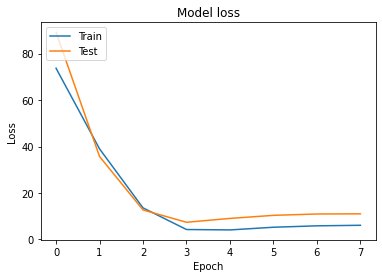

In [39]:
# 학습 손실 값과 검증 손실 값을 plotting 하여 epoch에 따른 loss의 변화를 살펴봅니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
result = pd.DataFrame()
result['actual_y'] = y_test

In [30]:
quantile = 0.1
# model compile 실행 시, loss 는 quantile loss function 적용 & optimizer는 adam을 적용
# Keras는 사용자 정의 손실에서 두 개의 입력만 허용합니다.
model.compile(optimizer='adam', loss=lambda y_p, y: quantile_loss(quantile, y_p, y))

# model fitting & prediction
history = model.fit(X_train, y_train, validation_split=0.25, epochs=8, verbose=1)
prediction = model.predict(X_test)

Epoch 1/8
4/4 [==============================] - 0s 43ms/step - loss: 73.6967 - val_loss: 89.1764
Epoch 2/8
4/4 [==============================] - 0s 8ms/step - loss: 39.0032 - val_loss: 35.7160
Epoch 3/8
4/4 [==============================] - 0s 10ms/step - loss: 13.5967 - val_loss: 12.7015
Epoch 4/8
4/4 [==============================] - 0s 7ms/step - loss: 4.2825 - val_loss: 7.3986
Epoch 5/8
4/4 [==============================] - 0s 10ms/step - loss: 4.1106 - val_loss: 9.0581
Epoch 6/8
4/4 [==============================] - 0s 8ms/step - loss: 5.2614 - val_loss: 10.3810
Epoch 7/8
4/4 [==============================] - 0s 9ms/step - loss: 5.8692 - val_loss: 10.9603
Epoch 8/8
4/4 [==============================] - 0s 10ms/step - loss: 6.1068 - val_loss: 11.0344


In [31]:
result['q-0.1'] = prediction

In [32]:
# 분위수 별로 prediction한 결과를 붙여줍니다.
result.sample()

,actual_y,q-0.5,q-0.975,q-0.025,q-0.1
134,419.0,424.567444,562.168945,261.247803,284.873749


In [33]:
# 날짜 column
result['month'] = list(pd.date_range('1960-01-01','1960-12-01', freq='MS').strftime('%Y-%m-%d'))

In [34]:
result['month'] = result['month'].apply(lambda x: '-'.join(x.split('-')[:2]))

In [36]:
result = result[['month','actual_y', 'q-0.025','q-0.1','q-0.5','q-0.975']]

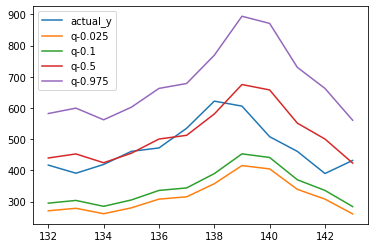

In [37]:
result.plot()

# under prediction in quantile 0.1 & 0.025
# over prediction in quantile 0.5 & 0.975

분위수별로 lower, 혹은 upper prediction되는 것을 확인할 수 있습니다. 

이러한 특징으로 인해 위에서 말한 구간 예측에 사용되며, 또한 과대/과소예측이 필요한 데이터에도 적용가능합니다.

### USE-CASE 2. Predict house price using scikit-learn
면적에 따른 집 값 예측

In [38]:
fname = '/content/drive/MyDrive/publicai/quantile-regression-main/data/house pricing delhi- MagicBricks.csv'
house_price = pd.read_csv(fname)
house_price.sample(4)

,Area,BHK,Bathroom,Furnishing,Location,District,Locality,Parking,Status,Transaction,Type,Per_Sqft,Price
165,1800.0,3,3.0,Furnished,Patel Nagar,West Delhi,"Patel Nagar East, Patel Nagar",3.0,Ready_to_move,Resale,Apartment,27778.0,50000000
819,850.0,2,3.0,Semi-Furnished,Patel Nagar,West Delhi,Patel Nagar West,1.0,Ready_to_move,Resale,Builder_Floor,24718.0,5900000
560,1250.0,3,3.0,Semi-Furnished,Alaknanda,South Delhi,"Narmada Apartment, Alaknanda",2.0,Ready_to_move,New_Property,Apartment,NaN,20000000
986,2700.0,4,4.0,Unfurnished,Greater Kailash,South Delhi,Greater Kailash 4 Nri Colony,2.0,Ready_to_move,Resale,Builder_Floor,12500.0,36500000


In [42]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Area         1214 non-null   float64
 1   BHK          1214 non-null   int64  
 2   Bathroom     1212 non-null   float64
 3   Furnishing   1214 non-null   object 
 4   Location     1214 non-null   object 
 5   District     1214 non-null   object 
 6   Locality     1214 non-null   object 
 7   Parking      1182 non-null   float64
 8   Status       1214 non-null   object 
 9   Transaction  1214 non-null   object 
 10  Type         1209 non-null   object 
 11  Per_Sqft     973 non-null    float64
 12  Price        1214 non-null   int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 123.4+ KB


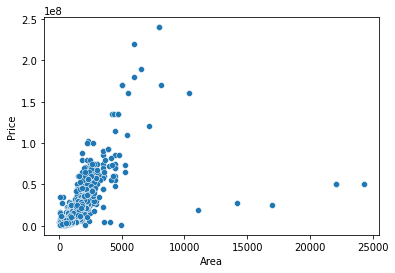

In [44]:
# 면적과 집값의 산점도를 확인해봅니다.
sns.scatterplot(data = house_price,x = 'Area', y = 'Price')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


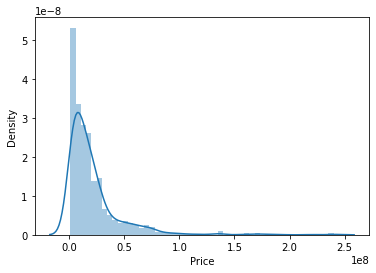

In [49]:
# price변수가 정규분포를 따르지 않음을 확인할 수 있습니다.
sns.distplot(house_price['Price'])

In [50]:
house_price.shape

(1214, 13)

#### 이번 예제에서는 선형회귀의 결과와 비교해보도록 하겠습니다.

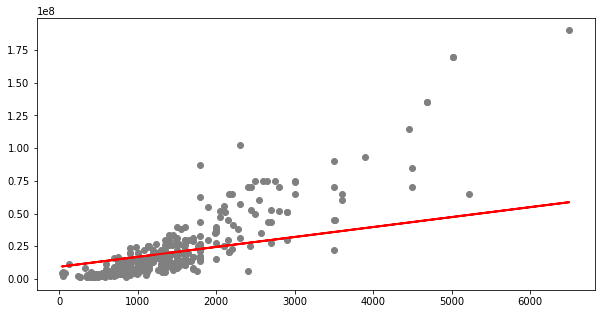

In [54]:
# linear regression을 이용한 prediction

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = house_price[['Area']]
y = house_price['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# 사용할 변수 선정
X = house_price[['Area']]
y = house_price['Price']

# 모델 생성 및 fitting & prediction
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
prediction = lm_model.predict(X_test)

# prediction결과를 실제와 비교
plt.figure(figsize = (10,5))
plt.scatter(X_test, y_test, color ='gray')
plt.plot(X_test, prediction, color ='red', linewidth=2)
plt.show()

# 이상치 데이터에서의 예측 성능은 떨어지는 경향을 보입니다.

In [90]:
X_test[:2]

,Area
739,1200.0
788,540.0


In [127]:
# quantile regression

# model 구축
train_df = pd.concat([X_train, y_train],axis=1)

quantiles = [0.025, 0.1, 0.5, 0.975]
pred_dict = {}
for tau in quantiles:
    qr_model = smf.quantreg('Price ~ Area', train_df).fit(q=tau)
    pred_y = qr_model.predict(X_test)
    pred_dict[str(tau)] = pred_y

pred_df = pd.concat(
                                    [X_test.reset_index(drop=True), 
                                     pd.DataFrame(pred_dict).reset_index(drop=True), 
                                     y_test.reset_index(drop=True)],
                                     axis=1,
                                     )

pred_df.isna().sum()

Area     0
0.025    0
0.1      0
0.5      0
0.975    0
Price    0
dtype: int64

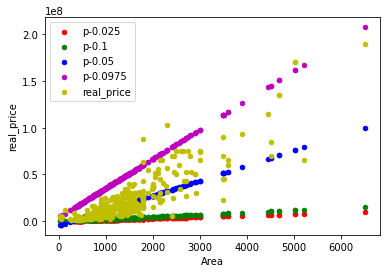

In [152]:
#pred_df = pred_df.rename(columns = {'Price':'real_price'})
ax1 = pred_df.plot(kind='scatter', x='Area', y='0.025', color='r', label = 'p-0.025')    
ax2 = pred_df.plot(kind='scatter', x='Area', y='0.1', color='g', ax=ax1, label = 'p-0.1')    
ax3 = pred_df.plot(kind='scatter', x='Area', y='0.5', color='b', ax=ax1, label = 'p-0.05')
ax4 = pred_df.plot(kind='scatter', x='Area', y='0.975', color='m', ax=ax1, label = 'p-0.0975')
ax5 = pred_df.plot(kind='scatter',x='Area',y='real_price',color='y',ax=ax1, label = 'real_price')
plt.legend()

plt.show(ax1 == ax2 == ax3 == ax4)

위 그림으로 확인할 수 있듯이, 분위수를 조절하며 기존 선형 회귀 모델에서는 하지 못했던 아웃라이어의 포용의 정도를 정할 수 있습니다.

### USE-CASE 3. predict ETA(estimated time of arrival)
거리에 따른 배달시간 예측

In [153]:
from sklearn.datasets import make_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [155]:
#회귀분석용 가상데이터 생성하여 '거리'와 '소요시간' 데이터를 만들어보겠습니다.
X, y = make_regression(n_samples=10000,
                n_features=1,
                n_informative=1,
                n_targets=1,
                random_state=42)

# 거리 -> 소요시간 column을 생성합니다.
Xs = pd.DataFrame(X, columns = ['distance'])
ys = pd.DataFrame(y, columns = ['time_to_buyer'])

dist_df = pd.DataFrame()
dist_df['distance'] = Xs['distance'].apply(lambda x: 10 + 2 * (x + np.random.normal(loc=1))  )
dist_df['time_to_buyer'] = ys['time_to_buyer'].apply(lambda x: 60 + 0.3* (x + np.random.normal(loc=1)) )

del Xs, ys
gc.collect()

dist_df.sample(4)

,distance,time_to_buyer
6447,11.131792,51.802757
9310,10.027916,60.928566
9188,9.725378,56.260691
6903,12.985085,70.166858


In [157]:
# train set과 test set으로 나눠줍니다.
train_df, test_df = train_test_split(dist_df, test_size=0.3, shuffle=False)
X_train, y_train = train_df[['distance']], train_df['time_to_buyer']
X_test, y_test = test_df[['distance']], test_df['time_to_buyer']

In [158]:
pred_dict = {}
# quantile 지정 : 0.1,0.5,0.9 (3개의 분위수에서 소요예상시간을 prediction합니다.)
for tau in quantiles:
    lgbm_model = LGBMRegressor(objective='quantile', alpha=tau)
    lgbm_model.fit(X_train, y_train)
    pred_y = lgbm_model.predict(X_test)
    pred_dict[str(tau)] = pred_y

pred_df = pd.concat(
                                    [X_test.reset_index(drop=True), 
                                     pd.DataFrame(pred_dict).reset_index(drop=True), 
                                     y_test.reset_index(drop=True)],
                                     axis=1,
                                     )

print(pred_df.isna().sum())

distance         0
0.025            0
0.1              0
0.5              0
0.975            0
time_to_buyer    0
dtype: int64


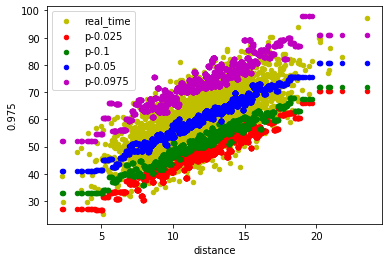

In [160]:
ax1 = pred_df.plot(kind='scatter',x='distance',y='time_to_buyer',color='y',label = 'real_time')
ax2 = pred_df.plot(kind='scatter', x='distance', y='0.025', color='r', ax=ax1, label = 'p-0.025')    
ax3 = pred_df.plot(kind='scatter', x='distance', y='0.1', color='g', ax=ax1, label = 'p-0.1')    
ax4 = pred_df.plot(kind='scatter', x='distance', y='0.5', color='b', ax=ax1, label = 'p-0.05')
ax5 = pred_df.plot(kind='scatter', x='distance', y='0.975', color='m', ax=ax1, label = 'p-0.0975')
plt.legend()

plt.show(ax1 == ax2 == ax3 == ax4)

In [161]:
pred_df.sample(1)

,distance,0.025,0.1,0.5,0.975,time_to_buyer
2963,12.605391,49.077898,55.314149,62.29627,75.311917,60.474954


해당 데이터도 위의 예제들과 같이 분위수가 높으면 과대예측에 가까워지는 것이 확인됩니다. 

이 결과를 통해 만약 buyer에게 분위수 "0.5 - 0.975" 범위로 ETA를 알려주기로 정한다면, 위 샘플데이터에서는 distance가 약 12.61인 곳의 예상 도착시간은 *62분 ~75분* 이 될 것입니다.

##### Notes
    - Instacart: https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb
    - Quantile Regression blog: http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html

### - 활용 사례
- quantile regression은 CNN과 결합되어 AMAZON Forecasting의 알고리즘 중 하나로 사용되고 있습니다.

    [aws_cnn_qr](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/aws-forecast-algo-cnnqr.html#aws-forecast-algo-cnnqr-getting-started)

##### - 참고자료

[simple understand of qunatile regression](http://ds.sumeun.org/?p=2173)

[what is quantile regression](https://jonsyou.tistory.com/14)

[Tech Blog: quantile loss function in machine learning](https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/)

[Prediction Intervals in Forecasting: Quantile Loss Function](https://medium.com/analytics-vidhya/prediction-intervals-in-forecasting-quantile-loss-function-18f72501586f)

[ETA prediction : quantile regression explained - Youtube Video](https://www.youtube.com/watch?v=JvIzB3hULCo)

[ETA prediction : quantile regression explained - Github Code](https://github.com/ajhalthor/quantile-regression)

[aws_cnn_qr](https://docs.aws.amazon.com/ko_kr/forecast/latest/dg/aws-forecast-algo-cnnqr.html#aws-forecast-algo-cnnqr-getting-started)